In [11]:
import numpy as np
import pandas as pd
import owlready2 as owl
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
table = pd.read_csv("./Data/vartest.tsv", sep='\t')
table2 = table.iloc[:, [0,1,2,3,6,8,22,24,25,26,40]].sort_values("Pathogenicity Score", ascending=False).loc[table["Pathogenicity Score"] >= 15]

In [13]:
hpo2diag = pd.read_csv("./Data/maxo_diagnostic_annotations2.txt", sep='\t')

In [14]:
gene2phen = pd.read_csv("./Data/genes_to_phenotype.txt", sep='\t')
gene2phen2 = gene2phen[gene2phen["gene_symbol"].isin(table2["Gene Symbol"])]

In [15]:
#### Find Unique Entries
##
gene2phen2sg = gene2phen2.drop_duplicates(subset=["gene_symbol"])
# print(gene2phen2sg.iloc[0]["gene_symbol"])

##
gene2phen2sp = gene2phen2.drop_duplicates(subset=["hpo_id"])
# print(gene2phen2sg.iloc[0]["hpo_id"])

## Show Relations
# for index, entry in gene2phen2.iterrows():
#     print(entry["gene_symbol"], entry["hpo_id"])

In [16]:
hpo2diags = hpo2diag.drop_duplicates(subset=["maxo_label"])

In [17]:
onto = owl.get_ontology("http://test.org/onto.owl")

with onto:
    
    class Gene(owl.Thing):
        pass
    class Phenotype(owl.Thing):
        pass
    class Measure(owl.Thing):
        pass
    class Diagnostic(Measure):
        pass
    
    class ConnectedTo(owl.Thing >> owl.Thing):
        pass

    
    for gene in gene2phen2sg["gene_symbol"]:
        my_new_gene = Gene(gene)
        
    for phen in gene2phen2sp["hpo_id"]:
        my_new_phen = Phenotype(phen)

    for diag in hpo2diags["maxo_label"]:
        my_new_diag = Diagnostic(diag)

    ## Insert Gene to Phenotype Relations
    gene_considered = gene2phen2.iloc[0]["gene_symbol"]
    phen_list = []
    for index, entry in gene2phen2.iterrows():
        if gene_considered == entry["gene_symbol"]:
            phen_list.append(Phenotype(entry["hpo_id"]))
        elif gene_considered is not entry["gene_symbol"]:
            Gene(gene_considered).ConnectedTo = phen_list
            # print(phen_list)
            phen_list = []
            gene_considered = entry["gene_symbol"]
            phen_list.append(Phenotype(entry["hpo_id"]))
    
    ## Insert Phenotype to Diagnostics Relations   
    phen_considered = hpo2diag.iloc[0]["hpo_id"]
    diag_list = []
    for index, entry in hpo2diag.iterrows():
        if phen_considered == entry["hpo_id"]:
            diag_list.append(Diagnostic(entry["maxo_label"]))
        elif phen_considered is not entry["hpo_id"]:
            Phenotype(phen_considered).ConnectedTo = diag_list
            #print(diag_list)
            diag_list = []
            phen_considered = entry["hpo_id"]
            diag_list.append(Diagnostic(entry["maxo_label"]))

In [18]:
print(len(onto.Gene.instances()))
print(len(onto.Phenotype.instances()))
print(len(onto.Diagnostic.instances()))

#for i in onto.Gene.instances():
#    print(i, i.ConnectedTo)
    
#print(onto.Gene.instances()[1], onto.Gene.instances()[1].ConnectedTo)

#for i in onto.Phenotype.instances():
#    print(i, i.ConnectedTo)


36
16395
258


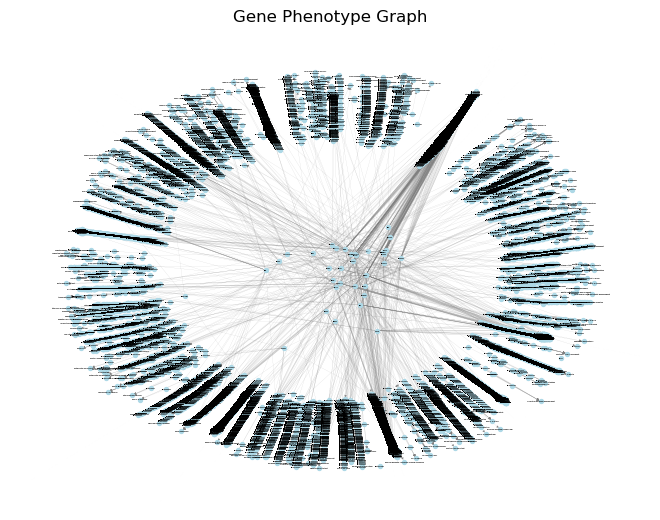

In [19]:
G = nx.DiGraph()

# 添加节点和边
for nodediag in onto.Diagnostic.instances():
    G.add_node(nodediag.name, label=nodediag.is_a[0].name)
for nodephen in onto.Phenotype.instances():
    G.add_node(nodephen.name, label=nodephen.is_a[0].name)
for nodegene in onto.Gene.instances():
    G.add_node(nodegene.name, label=nodegene.is_a[0].name)
    for genephenconnected in nodegene.ConnectedTo:
        G.add_edge(nodegene.name, genephenconnected.name)
for nodephen in onto.Phenotype.instances():
    for phendiagconnected in nodephen.ConnectedTo:
        G.add_edge(nodephen.name, phendiagconnected.name)

# 绘制网络图
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', width = 0.05, arrowsize = 4, node_size=8, font_size=1, font_weight='bold')

# 显示图
plt.title("Gene Phenotype Graph")
#plt.savefig("GenoPhenoKG.pdf")
plt.show()
#https://github.com/zhiyzuo/python-tutorial/blob/master/3-Network-Analysis-with-NetworkX.ipynb
#https://deepnote.com/app/siriuslabs/3D-network-visualisations-using-plotly-99361a50-d639-4371-9a7f-ff6e70184e02
# 1. for all diag_nodes build subgraph between diag_node (.subgraph(nodes=[i,onto.Diagnostic.instances()]))  and all geno_nodes, remove isolates (all geno_nodes not connected to diag_node), extract metrics from subgraph, repeat...

In [20]:
#print(nx.adjacency_matrix(G))